In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import string 
import datetime
import gzip

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
url_review = '/content/drive/My Drive/Data/steam_reviews.json.gz'

In [4]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 15
for l in parse(url_review):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

data_reviews = pd.DataFrame(data_reviews)

In [7]:
url_games = '/content/drive/My Drive/Data/steam_games.json.gz'

In [8]:
data_games = []
for l in parse(url_games):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

https://towardsdatascience.com/steam-recommendation-systems-4358917288eb

# Parte A Exploración de datos

## Reviews

In [9]:
data_reviews.head(4)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Duha Nubie,11.3,73.0,35140,4,2018-01-03,first debut feel sweet,False,1,NaN,NaN,NaN
2,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
3,S0YxSauCe,0.3,902.0,671270,4,2017-07-10,Easy game. All you have to do is put the hat t...,False,1,NaN,NaN,NaN


In [10]:
data_reviews.shape

(519538, 12)

In [11]:
data_reviews.dtypes

username         object
hours           float64
products        float64
product_id       object
page_order        int64
date             object
text             object
early_access       bool
page              int64
user_id          object
compensation     object
found_funny     float64
dtype: object

In [12]:
#Elimino columnas
data_reviews.drop(['page_order', 'page', 'early_access', 'compensation'], axis=1, inplace=True)

In [13]:
def valores_nulos(data):
  print('<-- Porcentaje de valores nulos -->\n')
  print(data.isnull().sum() / data.shape[0] * 100)

In [14]:
valores_nulos(data_reviews)

<-- Porcentaje de valores nulos -->

username        0.000000
hours           0.338763
products        0.193826
product_id      0.000000
date            0.000000
text            0.000000
user_id        59.197210
found_funny    84.535876
dtype: float64


In [15]:
print('Un total de {} usuarios realizaron reviews de videojuegos'.format(len(data_reviews.username.unique())))

Un total de 388028 usuarios realizaron reviews de videojuegos


In [16]:
print("<-- Top 10 de Usuarios con mas reviews -->")
data_reviews.username.value_counts().head(10)

<-- Top 10 de Usuarios con mas reviews -->


Alex           135
123            123
Nick           103
Jack           100
Chris           93
Dan             83
Matt            83
Sam             82
Saint Aaron     76
Kodyd194        73
Name: username, dtype: int64

In [17]:
print('<-- Top 10 Videojuegos con mas reviews -->\n ')
top_games = data_reviews.product_id.value_counts().head(10)
i = 0
while i <= 9:
  ids = top_games.index[i]
  ids = data_games[data_games['id'] == ids]
  print('-->', ids.title.iloc[0])
  i = i + 1

<-- Top 10 Videojuegos con mas reviews -->
 
--> Team Fortress 2
--> Rust
--> Borderlands 2
--> Fallout 4
--> Grand Theft Auto V
--> Portal 2
--> Undertale
--> DayZ
--> Warframe
--> Life is Strange - Episode 1


In [18]:
#Convertir a string columnas
columnas = ['username', 'text']
for i in columnas:
  data_reviews[i] = data_reviews[i].astype('string')

#Convertir a int64 columna product_id
data_reviews['product_id'] = data_reviews['product_id'].astype('int64')

In [19]:
#Conversion a tipo datetime64
data_reviews['Fecha'] = pd.to_datetime(data_reviews['date'])
data_reviews['Year'] = data_reviews['Fecha'].dt.year            #Nueva columna con el año del review
data_reviews['month'] = data_reviews['Fecha'].dt.month          #Nueva columna con el mes del review

In [20]:
year_review = data_reviews.groupby(['Year']).count()
year_review

,username,hours,products,product_id,date,text,user_id,found_funny,Fecha,month
Year,,,,,,,,,,
2010,850,825,847,850,850,850,136,24,850,850
2011,4983,4857,4979,4983,4983,4983,1014,168,4983,4983
2012,6721,6594,6714,6721,6721,6721,1656,208,6721,6721
2013,21887,21702,21856,21887,21887,21887,6841,854,21887,21887
2014,78862,78861,78514,78862,78862,78862,31222,5531,78862,78862
2015,105251,104526,105149,105251,105251,105251,42193,19987,105251,105251
2016,136073,135693,135854,136073,136073,136073,56404,26292,136073,136073
2017,161474,161290,161189,161474,161474,161474,70935,26918,161474,161474
2018,3437,3430,3429,3437,3437,3437,1585,360,3437,3437


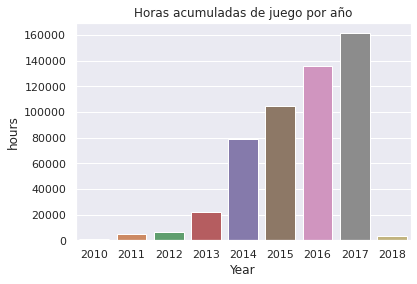

In [21]:
plt.title('Horas acumuladas de juego por año')
sns.barplot(x = year_review.index,
            y=year_review.hours)

In [22]:
months_2017 = data_reviews[data_reviews['Year'] == 2017].groupby(['month']).count()

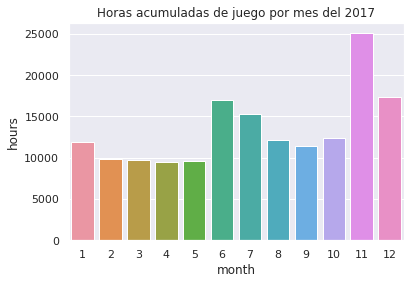

In [23]:
plt.title('Horas acumuladas de juego por mes del 2017')
sns.barplot(x= months_2017.index,
            y=months_2017.hours)

 ## Info Games

In [24]:
data_games.shape

(32135, 16)

In [25]:
data_games.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
id                 object
developer          object
sentiment          object
metascore          object
dtype: object

In [26]:
data_games.drop(['reviews_url', 'url', 'early_access', 'discount_price'],
                axis=1,
                inplace=True)

In [27]:
data_games.head(2)

,publisher,genres,app_name,title,release_date,tags,specs,price,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,643980,Secret Level SRL,Mostly Positive,NaN


In [28]:
data_games.shape

(32135, 12)

In [29]:
valores_nulos(data_games)

<-- Porcentaje de valores nulos -->

publisher       25.056792
genres          10.216275
app_name         0.006224
title            6.379337
release_date     6.432239
tags             0.507235
specs            2.084954
price            4.285047
id               0.006224
developer       10.266065
sentiment       22.349463
metascore       91.669519
dtype: float64


In [30]:
print('<-- Desarrolladores con mas videojuegos registrados -->\n')
data_games.developer.value_counts().head(10)

<-- Desarrolladores con mas videojuegos registrados -->



Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Paradox Development Studio     156
Capcom                         130
Ronimo Games                   123
Choice of Games                100
Musopia                         95
Stainless Games                 95
Name: developer, dtype: int64

Text(0, 0.5, 'Frecuencia')

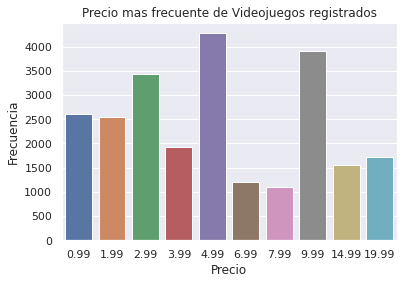

In [31]:
price_games = data_games.price.value_counts().head(10)
sns.barplot(x=price_games.index[0:],
            y=price_games)
plt.title('Precio mas frecuente de Videojuegos registrados')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# EDA

In [32]:
valores_nulos(data_games)

<-- Porcentaje de valores nulos -->

publisher       25.056792
genres          10.216275
app_name         0.006224
title            6.379337
release_date     6.432239
tags             0.507235
specs            2.084954
price            4.285047
id               0.006224
developer       10.266065
sentiment       22.349463
metascore       91.669519
dtype: float64


In [33]:
#Elimino valore nulos en data_games
data_games.dropna(subset=['tags', 'id', 'title'], axis=0, inplace=True)

In [34]:
#Convertir a string
data_games['genres'] = data_games['genres'].astype('string')
data_games['tags'] = data_games['tags'].astype('string')

In [35]:
data_games.head(2)

,publisher,genres,app_name,title,release_date,tags,specs,price,id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",[Single-player],4.99,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,643980,Secret Level SRL,Mostly Positive,NaN


In [36]:
#Submuestra
df_games = data_games.sample(frac=0.04)
df_games.reset_index(drop=True, inplace=True)

df_reviews = data_reviews.sample(frac=0.04)
df_reviews.reset_index(drop=True, inplace=True)

In [37]:
 #df_games['tags'] = df_games['tags'].fillna(' ')
 df_games['xtags'] = df_games['tags'].str.replace('[{}]'.format(string.punctuation), ' ')

In [38]:
df_games.head(2)

,publisher,genres,app_name,title,release_date,tags,specs,price,id,developer,sentiment,metascore,xtags
0,"Gaslamp Games, Inc.","['Casual', 'Indie', 'RPG']",Dungeons of Dredmor,Dungeons of Dredmor,2011-07-13,"['Rogue-like', 'Turn-Based', 'RPG', 'Indie', '...","[Single-player, Steam Achievements, Steam Trad...",4.99,98800,"Gaslamp Games, Inc.",Very Positive,79,Rogue like Turn Based RPG Indie ...
1,Rhino Games,"['Action', 'Adventure', 'Casual', 'Indie']",Cuco,Cuco,2017-09-29,"['Action', 'Adventure', 'Indie', 'Casual']","[Single-player, Steam Achievements, Full contr...",0.99,715720,Yah_Shi,9 user reviews,NaN,Action Adventure Indie Casual


# Recomendaciones

In [40]:
stopwords = nltk.corpus.stopwords.words('english')        #Defino las stopwords
tfidf = TfidfVectorizer(stop_words=set(stopwords))        #Defino el modelo
tfidf_matrix = tfidf.fit_transform(df_games['xtags'])   #Creo matriz

In [41]:
'''
Matriz de comparación
Compara las etiquetas de un video seleccionado con la lista anterior
en busca de palabras similares
'''
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [42]:
print(len(tfidf.vocabulary_))
print(tfidf_matrix.shape)

335
(1197, 335)


In [43]:
indices = pd.Series(df_games.index, index=df_games['title']).drop_duplicates()

In [44]:
def get_recomendation(title, cosine_sim=cosine_sim):
    idx = indices[title]                                                        #Selecciona el titulo del videojuego                        
    sim_scores = list(enumerate(cosine_sim[idx]))                               
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)           #Ordena de mayor a menor las similitudes
    sim_scores = sim_scores[1:6]                                                #Selecciona las primero 5 similitudes
    games_indices = [i[0] for i in sim_scores]
    return df_games['title'].iloc[games_indices]                                #Retorna el nombre de los videojuegos

In [47]:
def recomendation():
  '''
  Se seleccionara un id de un videojuego al azar, simulando que el usuario ya selecciono
  el videojuego que va jugar y escribir su reseña'''
  ids  = np.random.randint(df_games.shape[0])                         #Obtiene una linea al azar
  ids  = df_games.id.iloc[ids]                                        #Obtiene el id del videojuego seleccionado al azar
  name = (df_games.loc[df_games['id'] == ids]['title']).iloc[0]       #Busca el nombre del id del videojuego 
  print('Usted ha jugado: {}'.format(name))
  input('Ingrese su reseña: ')
  print('\nNuestras recomendaciones:')
  print(get_recomendation(name))

In [48]:
recomendation()

Usted ha jugado: TankZone Battle
Ingrese su reseña: excelente

Nuestras recomendaciones:
612                           PlanetSide 2
39           Military Life: Tank Simulator
1112       Tom Clancy's Rainbow Six® Vegas
466     White Noise 2 - Corey &amp; Shaira
240                         Sniper Elite 3
Name: title, dtype: object


# Procesamiento de lenguaje natural

In [ ]:
from textblob import TextBlob
import nltk
import goslate
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
data_reviews.head(2)

In [ ]:
valores_nulos(data_reviews)


https://www.youtube.com/watch?v=oy1lcj8s8sQ&t=620s  -->PRocesamiento de comentario

https://stackoverflow.com/questions/57744725/how-to-convert-emojis-emoticons-to-their-meanings-in-python --> Convertir emojis to text


In [ ]:
#Defino el modelo para traduccion
gs = goslate.Goslate()

In [ ]:
  s = data_reviews.text.iloc[2]

In [ ]:
TextBlob(s).translate(to = 'en')

In [ ]:
for i in range(data_reviews.shape[0]):
  reviews = data_reviews.text.iloc[i]
  data_reviews['Traduccion'] = gs.translate(reviews,'en')

In [ ]:
pip install goslate

In [ ]:
import goslate

In [ ]:
text = "Hello World"

gs = goslate.Goslate()
translatedText = gs.translate(text,'es')

In [ ]:
print(translatedText)

In [ ]:
for i in range(data_reviews.shape[0]):
  reviews = data_reviews.text.iloc[i]
  data_reviews['Traduccion'] = TextBlob(reviews).detect_language()

In [ ]:
import emoji

In [ ]:
corazon = '😁'

In [ ]:
print(emoji.demojize(corazon))

In [ ]:
s = emoji.demojize(corazon)

In [ ]:
print(s)

In [ ]:
a = data_reviews.text.iloc[6]

In [ ]:
print(emoji.demojize(a))

In [ ]:
reviews_text = []
for i in range(data_reviews.shape[0]):
    review = emoji.demojize(data_reviews.text.iloc[i])
    reviews_text.append(review)

In [ ]:
def listToString(s): 
    str1 = ""   
    for ele in s:  
        str1 += ele   
    return str1  

In [ ]:
data_reviews['no_emojis'] = listToString(reviews_text)

In [ ]:
data_reviews